In [1]:
# Packages
import gene_model
import gfs
import color_scheme
import hgt_mutations

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Simulation Parameters
theta = 2 # Gene Gain rate
rho = 0 # Gene Loss rate

gene_conv = 0 # Gene Conversion rate
recomb = 0 # Recombination rate
hgt_rate = 0.5 # HGT rate


num_sites = 1 # Number of sites to simulate
num_samples = 5 # Number of samples / individuals

Not enough hgt_edges, such that there doesn't have to be exactly one mutation.
0.0	('absent', 'present')	[1 0 1 1 1]
╔══╤════╤════╤══════════╤═════════════╤══════╤════════╗
║id│site│node│time      │derived_state│parent│metadata║
╠══╪════╪════╪══════════╪═════════════╪══════╪════════╣
║0 │   0│   5│0.38181875│      present│    -1│        ║
║1 │   0│   6│0.31550241│      present│    -1│        ║
╚══╧════╧════╧══════════╧═════════════╧══════╧════════╝



C:\Users\uhewm\OneDrive\PhD\Project No.2\pangenome-gene-transfer-simulation\gene_model.py:231: RuntimeWarning: 2 double mutation (present -> present) occured. It is recommended to increase the num_sites to 20 or higher. Alternatily use the double_site_relocation or relocate_double_gene_gain option.
  warnings.warn(


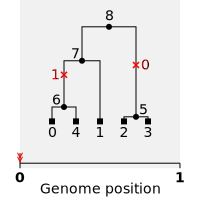

In [3]:
import numpy as np

run = True

while run:

    mts = gene_model.gene_model(
        theta=1,
        rho=rho,
        gene_conversion_rate=gene_conv,
        recombination_rate=recomb,
        hgt_rate=0.5,
        num_samples=num_samples,
        num_sites=num_sites,
        double_site_relocation=False, # Fix double gene gain events, won't hide the warning.
    )

    for var in mts.variants():
        #if not (var.alleles == ('absent',) or np.all(var.genotypes == [1, 1, 1, 1, 1])):
        #if not (var.alleles == ('present',)):
        run = False

for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

print(mts.tables.mutations)
mts.draw_svg()


In [57]:
print(mts.draw_text())



0.98┊                24    ┊
    ┊             ┏━━━┻━━┓ ┊
0.97┊            23      ┃ ┊
    ┊         ┏━━━┻━━━┓  ┃ ┊
0.92┊         ┃       ┃ 22 ┊
    ┊         ┃       ┃  ┃ ┊
0.92┊         ┃      20 21 ┊
    ┊         ┃       ┃    ┊
0.60┊        19       ┃    ┊
    ┊      ┏━━┻━━━┓   ┃    ┊
0.32┊     18      ┃   ┃    ┊
    ┊   ┏━━┻━━┓   ┃   ┃    ┊
0.28┊  17     ┃   ┃   ┃    ┊
    ┊ ┏━┻┓    ┃   ┃   ┃    ┊
0.28┊ ┃  ┃    ┃   ┃  16    ┊
    ┊ ┃  ┃    ┃   ┃   ┃    ┊
0.28┊ ┃ 14    ┃   ┃  15    ┊
    ┊ ┃  ┃    ┃   ┃        ┊
0.27┊ ┃  ┃   13   ┃        ┊
    ┊ ┃  ┃  ┏━┻┓  ┃        ┊
0.12┊ ┃ 12  ┃  ┃  ┃        ┊
    ┊ ┃  ┃  ┃  ┃  ┃        ┊
0.12┊ ┃ 11  ┃  ┃ 10        ┊
    ┊ ┃     ┃  ┃  ┃        ┊
0.07┊ ┃     9  ┃  ┃        ┊
    ┊ ┃    ┏┻┓ ┃  ┃        ┊
0.06┊ ┃    ┃ ┃ ┃  8        ┊
    ┊ ┃    ┃ ┃ ┃ ┏┻┓       ┊
0.05┊ ┃    ┃ 7 ┃ ┃ ┃       ┊
    ┊ ┃    ┃ ┃ ┃ ┃ ┃       ┊
0.05┊ ┃    ┃ 6 5 ┃ ┃       ┊
    ┊ ┃    ┃   ┃ ┃ ┃       ┊
0.00┊ 0    3   4 1 2       ┊
    0                      1



{(0.0, 1.0): [{(8, False)}, {(37, False)}, {(14, False)}, {(25, False)}, {(5, False)}, {(44, False)}, set(), set(), {(17, False), (10, True)}, {(10, False)}, {(21, False)}, set(), set(), set(), {(30, False)}, set(), set(), {(22, False), (19, True)}, {(19, False)}, {(21, False)}, set(), {(33, False)}, {(25, False)}, set(), set(), {(26, False)}, {(33, False)}, set(), set(), set(), {(37, False)}, set(), set(), {(44, False)}, set(), set(), set(), {(38, False)}, {(41, False)}, set(), set(), {(53, False)}, set(), set(), {(45, False)}, {(50, False)}, set(), set(), set(), set(), {(53, False)}, set(), set(), set(), set()], (1.0, 2.0): [{(8, False)}, {(37, False)}, {(14, False)}, {(25, False)}, {(5, False)}, {(44, False)}, set(), set(), {(17, False)}, set(), set(), set(), set(), set(), {(30, False)}, set(), set(), {(22, False)}, set(), set(), set(), set(), {(25, False)}, set(), set(), {(26, False)}, {(44, False)}, set(), set(), set(), {(37, False)}, set(), set(), set(), set(), set(), set(), {(38

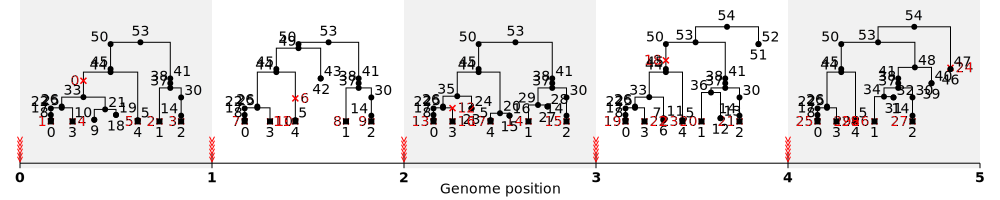

In [11]:
mts = gene_model.gene_model(
        theta=1,
        rho=0,
        gene_conversion_rate=gene_conv,
        recombination_rate=recomb,
        hgt_rate=0.5,
        num_samples=num_samples,
        num_sites=5,
        double_site_relocation=False, # Fix double gene gain events, won't hide the warning.
    )

for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

print(mts.draw_text())  
mts.draw_svg()



In [7]:

# Site und Node definieren
site_id = 4  # ID der Site
node_id = 0  # ID des Knotens

# Zugriff auf die Site und den Baum
site = mts.site(site_id)
tree = mts.at(site_id)

# Standardmäßig ist der Zustand der ancestrale Zustand
state = site.ancestral_state

# Iteriere durch die Mutationen der Site
for mutation in site.mutations:
    # Prüfe, ob der Knoten (oder einer seiner Vorfahren) von der Mutation betroffen ist
    print(tree.is_descendant(node_id, mutation.node))
    if tree.is_descendant(node_id, mutation.node):
        state = mutation.derived_state

print(f"Node {node_id} at site {site_id}: {state}")

print(tree.parent_dict)  # Zeigt die Eltern-Kind-Beziehungen im Baum

print(tree.is_descendant(0, 14))

site.mutations

True
True
False
False
False
False
Node 0 at site 4: absent
{0: 5, 1: 10, 2: 8, 3: 13, 4: 8, 5: 24, 8: 17, 10: 16, 13: 18, 14: 15, 15: 16, 16: 17, 17: 21, 18: 21, 21: 31, 24: 34, 31: 34}
False


[Mutation(id=24, site=4, node=24, derived_state='present', parent=-1, metadata=b'\x00', time=0.6867895706611306, edge=38),
 Mutation(id=25, site=4, node=0, derived_state='absent', parent=-1, metadata=b'\x01', time=1e-11, edge=0),
 Mutation(id=26, site=4, node=1, derived_state='absent', parent=-1, metadata=b'\x01', time=1e-11, edge=7),
 Mutation(id=27, site=4, node=2, derived_state='absent', parent=-1, metadata=b'\x01', time=1e-11, edge=2),
 Mutation(id=28, site=4, node=3, derived_state='absent', parent=-1, metadata=b'\x01', time=1e-11, edge=10),
 Mutation(id=29, site=4, node=4, derived_state='absent', parent=-1, metadata=b'\x01', time=1e-11, edge=3)]

In [12]:
import numpy as np

alleles = ["absent", "present"]

poisson = np.random.poisson(theta / (rho if rho != 0 else 1))
poisson = min(poisson, num_sites)

position = np.arange(0, num_sites, dtype="uint32")
position = np.random.choice(position, poisson, replace=False)
position.sort()

position

array([20, 46, 82, 87], dtype=uint32)

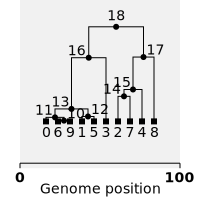

In [168]:
import msprime # Simulieren des Abstammungsbaumes
tree_sequence = msprime.sim_ancestry(samples=5, population_size=1, sequence_length=100, recombination_rate=0)

# Einführen von Mutationen, um Allel-Präsenzen zu erstellen
mutated_ts = msprime.sim_mutations(tree_sequence, rate=1e-4)

# Anzeigen aller Varianten
for variant in mutated_ts.variants():
    print("Position:", variant.site.position, "Alleles:", variant.alleles)

tree_sequence.draw_svg()

In [8]:
#poisson = np.random.poisson(theta / (rho if rho != 0 else 1))
#poisson = min(poisson, num_sites)
alleles = ["absent", "present"]
poisson = num_sites

position = np.arange(0, num_sites, dtype="uint32")
position = np.random.choice(position, poisson, replace=False)
position.sort()

ancestral_state = [alleles[0]] * poisson

position

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint32)

In [178]:
for variant in mutated_ts.variants():
    print("Position:", variant.site.position, "Alleles:", variant.alleles)

Position: 0.0 Alleles: ('A', 'T')
Position: 1.0 Alleles: ('T', 'A', 'G')
Position: 2.0 Alleles: ('T', 'A')
Position: 3.0 Alleles: ('T', 'G', 'C')
Position: 4.0 Alleles: ('G', 'A')
Position: 5.0 Alleles: ('T', 'C', 'A')
Position: 6.0 Alleles: ('T', 'C')
Position: 7.0 Alleles: ('T', 'C')
Position: 8.0 Alleles: ('G', 'T')
Position: 9.0 Alleles: ('C', 'A', 'G')


In [177]:
import msprime
import numpy as np

# Simulate the ancestry and add mutations
tree_sequence = msprime.sim_ancestry(samples=5, population_size=100, sequence_length=10, recombination_rate=1e-8)
mutated_ts = msprime.sim_mutations(tree_sequence, rate=0.01)

# Initialize with a presumed ancestral state (e.g., hypothetical 'A')
ancestral_alleles = ['A'] * int(mutated_ts.sequence_length)

# List encountered mutations and adjust from presumed ancestral state
for var in mutated_ts.variants():
    for i in range(len(var.alleles)):
        # var.alleles[i] might reveal distinct alleles related to original ancestral one
        print(f"Site: {int(var.site.position)} | Alleles: {var.alleles} | Genotypes: {var.genotypes}")

# Understanding: Original MRCA alleles are set as 'A' for non-affected order points assuming, but post-mutation interpretation inherits genoform modulations.

Site: 0 | Alleles: ('A', 'T') | Genotypes: [0 0 0 0 1 0 0 0 0 0]
Site: 0 | Alleles: ('A', 'T') | Genotypes: [0 0 0 0 1 0 0 0 0 0]
Site: 1 | Alleles: ('T', 'A', 'G') | Genotypes: [1 2 1 0 0 1 0 0 1 0]
Site: 1 | Alleles: ('T', 'A', 'G') | Genotypes: [1 2 1 0 0 1 0 0 1 0]
Site: 1 | Alleles: ('T', 'A', 'G') | Genotypes: [1 2 1 0 0 1 0 0 1 0]
Site: 2 | Alleles: ('T', 'A') | Genotypes: [0 0 0 0 0 0 0 0 0 1]
Site: 2 | Alleles: ('T', 'A') | Genotypes: [0 0 0 0 0 0 0 0 0 1]
Site: 3 | Alleles: ('T', 'G', 'C') | Genotypes: [0 2 2 2 0 0 0 0 0 0]
Site: 3 | Alleles: ('T', 'G', 'C') | Genotypes: [0 2 2 2 0 0 0 0 0 0]
Site: 3 | Alleles: ('T', 'G', 'C') | Genotypes: [0 2 2 2 0 0 0 0 0 0]
Site: 4 | Alleles: ('G', 'A') | Genotypes: [0 0 0 0 1 0 0 0 0 0]
Site: 4 | Alleles: ('G', 'A') | Genotypes: [0 0 0 0 1 0 0 0 0 0]
Site: 5 | Alleles: ('T', 'C', 'A') | Genotypes: [2 0 0 0 1 2 0 1 2 0]
Site: 5 | Alleles: ('T', 'C', 'A') | Genotypes: [2 0 0 0 1 2 0 1 2 0]
Site: 5 | Alleles: ('T', 'C', 'A') | Genotypes: [2

In [161]:
import numpy as np
np.set_printoptions(linewidth=200)  # print genotypes on a single line

print("Genotypes")
for v in ts.variants():
    print(f"Site {v.site.id}: {v.genotypes}")
    

Genotypes
Site 0: [0 0 0 0 0]
Site 1: [0 0 0 0 0]
Site 2: [0 0 0 0 0]
Site 3: [0 0 0 0 0]
Site 4: [0 0 0 0 0]
Site 5: [0 0 0 0 0]
Site 6: [0 0 0 0 0]
Site 7: [0 0 0 0 0]
Site 8: [0 0 0 0 0]
Site 9: [0 0 0 0 0]
Site 10: [0 0 0 0 0]
Site 11: [0 0 0 0 0]
Site 12: [0 0 0 0 0]
Site 13: [0 0 0 0 0]
Site 14: [0 0 0 0 0]
Site 15: [0 0 0 0 0]
Site 16: [0 0 0 0 0]
Site 17: [0 0 0 0 0]
Site 18: [0 0 0 0 0]
Site 19: [0 0 0 0 0]
Site 20: [0 0 0 0 0]
Site 21: [0 0 0 0 0]
Site 22: [0 0 0 0 0]
Site 23: [0 0 0 0 0]
Site 24: [0 0 0 0 0]
Site 25: [0 0 0 0 0]
Site 26: [0 0 0 0 0]
Site 27: [0 0 0 0 0]
Site 28: [0 0 0 1 0]
Site 29: [0 0 0 0 0]
Site 30: [0 0 0 0 0]
Site 31: [0 0 0 0 0]
Site 32: [1 1 1 0 1]
Site 33: [0 0 0 0 0]
Site 34: [0 0 0 0 0]
Site 35: [0 0 0 0 0]
Site 36: [0 0 0 0 0]
Site 37: [0 0 0 0 0]
Site 38: [0 0 0 0 0]
Site 39: [0 0 0 0 0]
Site 40: [0 0 0 0 0]


In [82]:
ts = mts
print("There are", ts.num_nodes, "nodes, of which", ts.num_samples, "are sample nodes")

# mts.genotype_matrix()

node_id = 100  # Beispiel-ID des gewünschten Knotens/Wunschindividuums

for variant in ts.variants():
    allel_index = variant.genotypes[node_id]
    allel = variant.alleles[allel_index]
    print(f"Position: {variant.site.position}, Allel: {allel}")

There are 795 nodes, of which 5 are sample nodes


IndexError: index 100 is out of bounds for axis 0 with size 5

In [11]:
print("There are", ts.num_edges, "edges, one of which is:\n ", ts.edge(0))

There are 58 edges, one of which is:
  Edge(left=0.0, right=60000.0, parent=5, child=0, metadata=b'', id=0)


In [84]:
# Gehe zu einem bestimmten Baum in der Sequenz
tree = ts.first()

# Beispiel: Interner Knoten, den du untersuchen möchtest
internal_node_id = tree.parent(0)  # wähle ein Beispiel; dort parent eines Leaf-Nodes

# Verwende all_nodes() oder parent() Methoden, um interne Knoten zu identifizieren
children = list(tree.children(internal_node_id))

print("Kinder des spezifischen internen Knotens:", children)

# Wenn du die genetischen Infos erhalten willst über Blätter:
for variant in ts.variants():
    for child in children:
        genotype = variant.genotypes[child]
        allele = variant.alleles[genotype]
        print(f"Position: {variant.site.position}, Child Node Allele: {allele}")

Kinder des spezifischen internen Knotens: [0]
Position: 17.0, Child Node Allele: absent
Position: 23.0, Child Node Allele: absent
Position: 24.0, Child Node Allele: absent
Position: 28.0, Child Node Allele: absent
Position: 32.0, Child Node Allele: absent
Position: 37.0, Child Node Allele: absent
Position: 38.0, Child Node Allele: absent
Position: 44.0, Child Node Allele: absent
Position: 45.0, Child Node Allele: absent
Position: 48.0, Child Node Allele: absent
Position: 49.0, Child Node Allele: absent
Position: 51.0, Child Node Allele: present
Position: 54.0, Child Node Allele: absent
Position: 55.0, Child Node Allele: absent
Position: 56.0, Child Node Allele: present
Position: 59.0, Child Node Allele: absent
Position: 62.0, Child Node Allele: absent
Position: 63.0, Child Node Allele: absent
Position: 71.0, Child Node Allele: absent
Position: 76.0, Child Node Allele: absent
Position: 77.0, Child Node Allele: absent
Position: 89.0, Child Node Allele: absent
Position: 99.0, Child Node A

In [12]:
breakpoints = ts.breakpoints(as_array=True)
print("There are", ts.num_trees, "trees, associated with breakpoints", breakpoints)

There are 19 trees, associated with breakpoints [    0.   859.   860.  9499.  9500. 14823. 14824. 28834. 28835. 31702.
 31703. 36073. 36074. 47296. 47297. 50118. 50119. 53818. 53819. 60000.]


In [100]:
# ts.tables.sites

ts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,36,0.03431124,absent,-1,
1,0,0,0.00000000,absent,-1,
2,0,1,0.00000000,absent,-1,
3,0,2,0.00000000,absent,0,
4,0,3,0.00000000,absent,-1,
5,0,4,0.00000000,absent,-1,
6,1,407,0.40295404,absent,-1,
7,1,0,0.00000000,absent,-1,
8,1,1,0.00000000,absent,-1,
9,1,2,0.00000000,absent,-1,


In [89]:
import pandas as pd

mutated_ts = ts
# Liste, in der die Mutationsdaten gespeichert werden
mutation_data = []

pd.set_option('display.max_rows', None)  # Zeigt alle Zeilen an
pd.set_option('display.max_columns', None)  # Zeigt alle Spalten an

# Durchlaufe alle Varianten (Mutationen)
for variant in mutated_ts.variants():
    position = variant.site.position
    alleles = variant.alleles
    for sample_index, genotype in enumerate(variant.genotypes):
        allele = alleles[genotype]
        mutation_data.append({
            "Position": position,
            "Sample Index": sample_index,
            "Genotype": genotype,
            "Allele": allele
        })

# Erstelle ein DataFrame aus den Mutationsdaten
mutation_df = pd.DataFrame(mutation_data)

# Druck die Tabelle
print(mutation_df)

     Position  Sample Index  Genotype   Allele
0        17.0             0         0   absent
1        17.0             1         0   absent
2        17.0             2         0   absent
3        17.0             3         0   absent
4        17.0             4         0   absent
5        23.0             0         0   absent
6        23.0             1         0   absent
7        23.0             2         0   absent
8        23.0             3         0   absent
9        23.0             4         0   absent
10       24.0             0         0   absent
11       24.0             1         0   absent
12       24.0             2         0   absent
13       24.0             3         0   absent
14       24.0             4         0   absent
15       28.0             0         0   absent
16       28.0             1         0   absent
17       28.0             2         0   absent
18       28.0             3         0   absent
19       28.0             4         0   absent
20       32.0

In [23]:
first_tree = ts.first()
parent_of_7 = first_tree.parent(6)
children_of_7 = first_tree.children(6)
print("Node 7's parent is", parent_of_7, "and childen are", children_of_7, "in the first tree")
print(first_tree.draw_text())

Node 7's parent is 10 and childen are (1, 5) in the first tree
     39  
    ┏━┻━┓
   36   ┃
    ┃   ┃
    ┃  31
    ┃   ┃
    ┃  28
    ┃   ┃
    ┃  24
    ┃   ┃
   23   ┃
  ┏━┻━┓ ┃
  ┃  19 ┃
  ┃   ┃ ┃
  ┃   ┃16
  ┃   ┃ ┃
  ┃   ┃13
  ┃   ┃ ┃
 10   ┃ ┃
  ┃   ┃ ┃
  ┃   7 ┃
  ┃   ┃ ┃
  6   ┃ ┃
 ┏┻━┓ ┃ ┃
 5  ┃ ┃ ┃
┏┻┓ ┃ ┃ ┃
0 3 1 2 4



In [24]:
print(ts.site(0))  # For convenience, the Python API also returns the mutations at the site

Site(id=0, position=0.0, ancestral_state='present', mutations=[Mutation(id=0, site=0, node=1, derived_state='absent', parent=-1, metadata=b'', time=0.04115098429061284, edge=2), Mutation(id=1, site=0, node=0, derived_state='present', parent=-1, metadata=b'', time=1e-11, edge=0), Mutation(id=2, site=0, node=1, derived_state='absent', parent=0, metadata=b'', time=1e-11, edge=2), Mutation(id=3, site=0, node=2, derived_state='present', parent=-1, metadata=b'', time=1e-11, edge=4), Mutation(id=4, site=0, node=3, derived_state='present', parent=-1, metadata=b'', time=1e-11, edge=1), Mutation(id=5, site=0, node=4, derived_state='present', parent=-1, metadata=b'', time=1e-11, edge=8)], metadata=b'')
